In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:

# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(f"Xtr.shape, Ytr.shape: {Xtr.shape, Ytr.shape}")
print(f"Xdev.shape, Ydev.shape: {Xdev.shape, Ydev.shape}")
print(f"Xte.shape, Yte.shape: {Xte.shape, Yte.shape}")


Xtr.shape, Ytr.shape: (torch.Size([182625, 3]), torch.Size([182625]))
Xdev.shape, Ydev.shape: (torch.Size([22655, 3]), torch.Size([22655]))
Xte.shape, Yte.shape: (torch.Size([22866, 3]), torch.Size([22866]))


In [105]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # we can squash the weights 
# the gain is used to reboost the weeights atht eh tails of distribution isnce non-linearity squashes the weights. e.g. relu squashes everthing <1 to 0 a
#(torch.randn(10000)*0.2).std()  # we multiply the weights with std which turns out to be the same as the multiplier
# we want to multiply the std wihich is 
#(5/3) / (fan_in**0.5)
# fan_in is the number of input features to the layer, in out case block_size * n_embd = 3 * 10 = 30

#(5/3) / (30**0.5)
# so we multiply the weights with 0.29814239699992494
# this is the same as the multiplier we used in the Kaiming init
# so we can use the same multiplier for the weights initialization

# now letls changeh W1 to use Kaiming init
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01 # make it close to zero
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we multiply by 0.01 to make initial logits close to approx of 1/27
b2 = torch.randn((vocab_size), generator=g) * 0 # we want logits to be near zero for lower initial loss, so let's amke b2 zero

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [38]:
b2

tensor([0., 0., 0., 0., 0., 0., -0., 0., 0., -0., -0., -0., 0., 0., 0., 0., -0., 0., 0., -0., 0., -0., 0., 0.,
        0., -0., -0.], requires_grad=True)

In [106]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # flatten the batch and sequence dimensions

    hpreact = embcat @ W1 + b1 

    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2  # we want logits to be near zero for lower initial loss, so let's amke b2 zero
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break # stop after first pass and observe the lgoits whihc will be very high

      0/ 200000 loss: 3.3147
  10000/ 200000 loss: 2.2476
  20000/ 200000 loss: 1.9704
  30000/ 200000 loss: 2.2570
  40000/ 200000 loss: 2.5492
  50000/ 200000 loss: 2.4755
  60000/ 200000 loss: 2.1049
  70000/ 200000 loss: 1.7837
  80000/ 200000 loss: 2.1137
  90000/ 200000 loss: 2.2755
 100000/ 200000 loss: 2.0281
 110000/ 200000 loss: 2.1283
 120000/ 200000 loss: 2.3030
 130000/ 200000 loss: 1.9402
 140000/ 200000 loss: 2.1682
 150000/ 200000 loss: 2.0885
 160000/ 200000 loss: 1.6267
 170000/ 200000 loss: 1.7378
 180000/ 200000 loss: 2.1209
 190000/ 200000 loss: 2.1801


In [98]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0692827701568604
val 2.134324073791504


In [ ]:
# FIX SOFTMAX ISSUE

In [66]:
logits[0] 

tensor([-0.8329,  0.0103, -0.3449,  1.2626, -1.3373,  0.7066,  0.0531, -0.6044,
         0.7297, -0.3504, -1.1343,  2.8547, -0.9845, -1.3581,  0.2443,  0.0566,
        -2.3506,  1.2519, -1.1997,  0.4271,  0.6165, -0.7989,  1.7536,  0.2107,
         0.0475,  1.7926, -2.8022], grad_fn=<SelectBackward0>)

In [ ]:
# 4 dimensional example of issue with high loss at the start
test_logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # (tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))
test_logits = torch.tensor([-3.0, 5.0, 0.0, 0.0]) # this will make loss higher, with extrem values in logits
test_logits = torch.randn((4,)) * 10 # extreme values in logits
test_probs = F.softmax(test_logits, dim=0)
test_loss = -test_probs[2].log()
test_probs, test_loss

# WE WANT LOGITS TO BE APPROX. EQUAL

(tensor([2.2451e-06, 9.9904e-01, 9.5771e-04, 3.1277e-08]), tensor(6.9510))

In [9]:
# manually we expect the initall loss, assuming each carachter is equally likely to appear 
# to be -log(1/vocab_size) = -log(1/100) = 4.605
-torch.tensor(1/27.0).log()

tensor(3.2958)

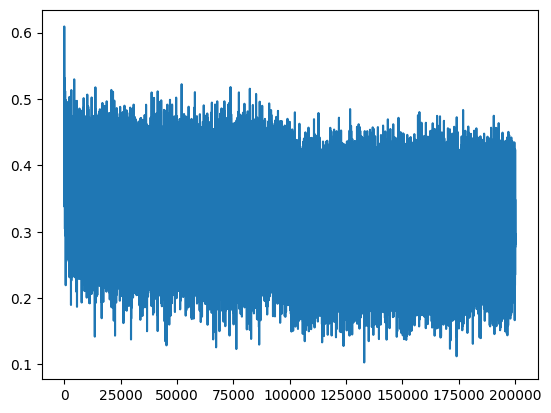

In [73]:
plt.plot(lossi)

In [ ]:
# ACTIVATION Issue
#  after fixing the logits issue, we see the h is tanh function whihc squashes the weights 
# we see h has values between -1 and 1 and many elements are 1 or -1. 
h

tensor([[ 0.0271, -1.0000, -1.0000,  ..., -0.9999, -1.0000,  0.9995],
        [-0.3639,  0.2040,  1.0000,  ...,  0.6901,  0.2010,  0.9998],
        [-1.0000,  0.8879, -1.0000,  ..., -1.0000,  0.7794,  0.1594],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000,  0.4226, -0.9997,  ..., -0.5684, -0.9411,  0.7337],
        [ 0.0830, -0.9999,  0.9990,  ..., -0.7998,  0.9251,  1.0000]],
       grad_fn=<TanhBackward0>)

(array([201., 180., 192., 157., 128., 136., 141., 127.,  95., 128., 107.,
        121., 110.,  91.,  90., 112.,  91., 102., 104.,  88.,  99., 108.,
        101.,  92., 101.,  96.,  80., 103., 100., 114., 104., 107., 110.,
        106., 125.,  96.,  93., 106., 102., 130., 122., 155., 146., 162.,
        145., 180., 185., 225., 239., 267.]),
 array([-9.99100864e-01, -9.59126867e-01, -9.19152870e-01, -8.79178873e-01,
        -8.39204876e-01, -7.99230880e-01, -7.59256883e-01, -7.19282886e-01,
        -6.79308889e-01, -6.39334892e-01, -5.99360895e-01, -5.59386898e-01,
        -5.19412901e-01, -4.79438905e-01, -4.39464908e-01, -3.99490911e-01,
        -3.59516914e-01, -3.19542917e-01, -2.79568920e-01, -2.39594923e-01,
        -1.99620926e-01, -1.59646930e-01, -1.19672933e-01, -7.96989357e-02,
        -3.97249389e-02,  2.49058008e-04,  4.02230549e-02,  8.01970518e-02,
         1.20171049e-01,  1.60145046e-01,  2.00119042e-01,  2.40093039e-01,
         2.80067036e-01,  3.20041033e-01,  3.60015

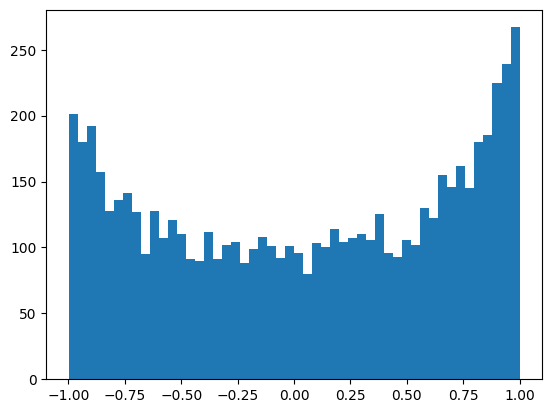

In [95]:
# lets get the hostogram of the values of h to see the distribution
h.shape # (N, n_hidden) (32, 200)
plt.hist(h.view(-1).tolist(), 50) # h.view(-1) flattens the tensor to (N * n_hidden,) (6400,)
# we see tanh is active for mostly at 1 or -1

# in the backward pass, the gradient of tanh is 1 - tanh(x)^2 * out.grad
# def tanh(self):
#         x = self.data
#         t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#         out = Value(t, (self,), 'tanh')

#         def _backward():
#             self.grad = (1 - t**2) * out.grad
#         out._backward = _backward  # NOTE: no () - assign function, don't call it
#         return out

# if output of tanh is inteh tail e.g. at 1 or -1, the change in input is not going to impact the output


(array([  1.,   2.,   4.,   4.,   6.,  11.,  17.,  26.,  23.,  26.,  63.,
         41.,  89., 127., 139., 207., 213., 273., 318., 309., 369., 404.,
        375., 422., 406., 367., 350., 293., 299., 260., 188., 194., 171.,
        110.,  87.,  53.,  46.,  31.,  27.,  11.,  12.,   8.,   6.,   9.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([-1.94856203, -1.86371318, -1.77886433, -1.69401548, -1.60916663,
        -1.52431778, -1.43946893, -1.35462008, -1.26977123, -1.18492238,
        -1.10007353, -1.01522468, -0.93037583, -0.84552698, -0.76067813,
        -0.67582928, -0.59098043, -0.50613158, -0.42128273, -0.33643388,
        -0.25158503, -0.16673618, -0.08188733,  0.00296152,  0.08781037,
         0.17265922,  0.25750807,  0.34235692,  0.42720577,  0.51205462,
         0.59690347,  0.68175232,  0.76660117,  0.85145002,  0.93629887,
         1.02114772,  1.10599657,  1.19084542,  1.27569427,  1.36054312,
         1.44539196,  1.53024081,  1.61508966,  1.69993851,  1.78478736,
 

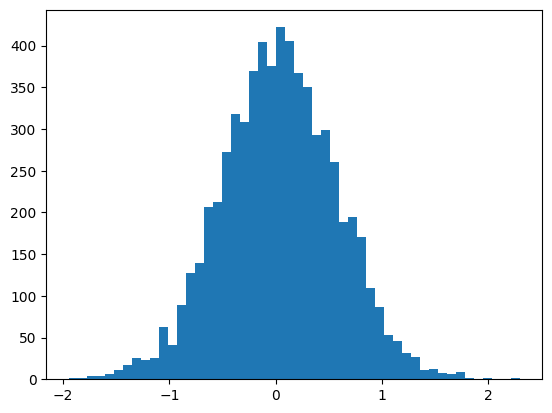

In [91]:
# this is because pre-activation is too broad 
plt.hist(hpreact.view(-1).tolist(), 50)

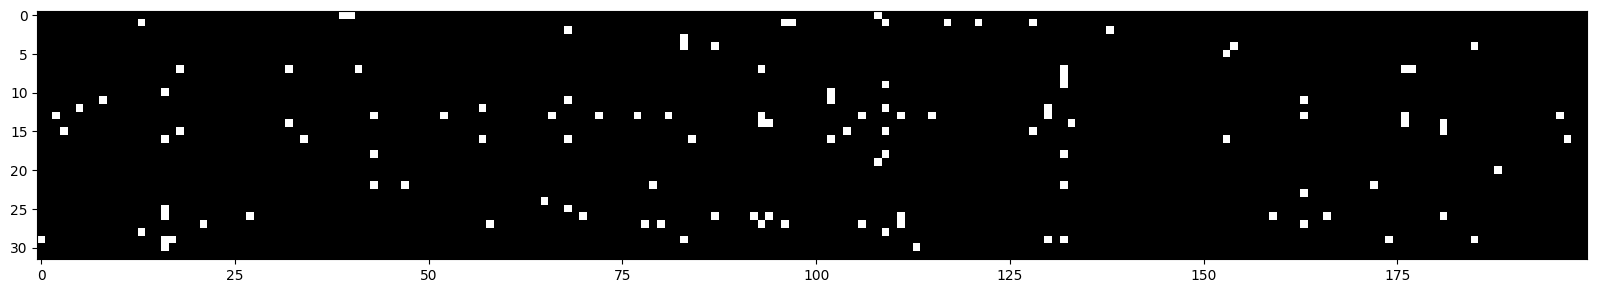

In [96]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# white if > 0.99, black if < 0.99
# many are white, tanh is saturated with values at 1 or -1
# if the whole column is white then neoron is dead for that input, backward grad will be 0


In [ ]:
# there are other non-linearities that are not saturated e.g. relu, elu, gelu, swi-lu, mish, etc.
# relu neoron can be dead for certain type of initialization
# how do we fix this
#emb = C[Xb] #comes from gaussian  (N, block_size, n_embd)
#hpreact = embcat @ W1 + b1 # (N, n_hidden) gets multiplied by W1 adn b1. 
# we add 

tensor(0.0009) tensor(0.1986)
tensor(-0.0027) tensor(0.6477)


(array([3.49603062e-05, 1.39841225e-04, 0.00000000e+00, 1.39841225e-04,
        3.14642756e-04, 6.29285511e-04, 1.04880919e-03, 2.09761837e-03,
        3.00658633e-03, 4.92940317e-03, 7.69126736e-03, 1.22011469e-02,
        2.17802707e-02, 3.57294329e-02, 5.48527204e-02, 8.39047348e-02,
        1.22745635e-01, 1.72144548e-01, 2.36366630e-01, 3.15586684e-01,
        4.16796770e-01, 5.01610473e-01, 5.76355608e-01, 6.25055314e-01,
        6.55750463e-01, 6.37396302e-01, 5.75236878e-01, 4.90737818e-01,
        3.99421498e-01, 3.10762162e-01, 2.31227465e-01, 1.66725700e-01,
        1.14285241e-01, 7.81013240e-02, 5.26502211e-02, 3.19886801e-02,
        1.98224936e-02, 1.33198767e-02, 7.65630705e-03, 4.71964133e-03,
        3.04154664e-03, 1.78297561e-03, 8.39047348e-04, 7.69126736e-04,
        4.19523674e-04, 2.09761837e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.49603062e-05]),
 array([-3.49870086, -3.35568151, -3.21266217, -3.06964283, -2.92662349,
        -2.78360415, 

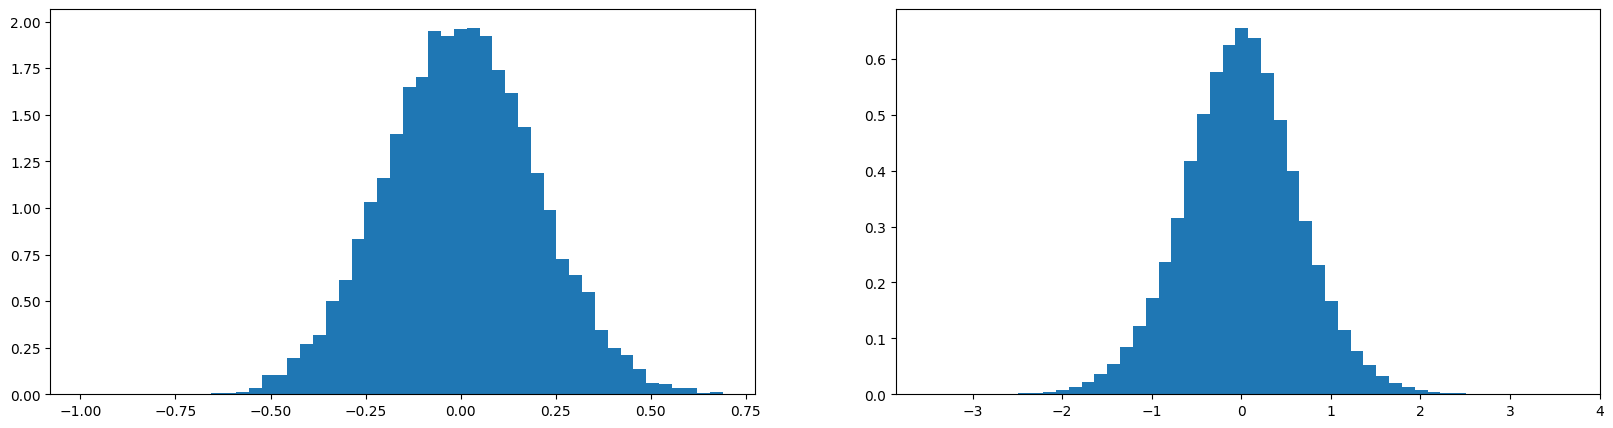

In [ ]:
# now for deeper netwropk, we update the netowrk code
# so how to optimise the W1, b1, W2, b2 initilisation for large netowrks
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5# this will make y to had std of 5*3 = 15
w = torch.randn(10, 200) * 0.2  # tif we shrink this, y will shrink


# in pytorch Kaiming init is the default for linear layers
# the gain is used to reboost the weeights atht eh tails of distribution isnce non-linearity squashes the weights. e.g. relu squashes everthing <1 to 0 a
# WHAT MULTIPLIER WEE USE TO KEEP THE DISTRIBUTION OF y THE SAME AS x
# mathematically, if we want to keep the distribution of y the same as x, we need to divide by the square root of the number of rows in x

w = torch.randn(10, 200) / 10**0.5 # Kaimming initilisation
y = x @ w # Gaussian expands 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)




In [ ]:
# in pytorch Kaiming init is the default for linear layers
# the gain is used to reboost the weeights atht eh tails of distribution isnce non-linearity squashes the weights. e.g. relu squashes everthing <1 to 0 a
(torch.randn(10000)*0.2).std()  # we multiply the weights with std which turns out to be the same as the multiplier
# we want to multiply the std wihich is 
#(5/3) / (fan_in**0.5)
# fan_in is the number of input features to the layer, in out case block_size * n_embd = 3 * 10 = 30

(5/3) / (30**0.5)
# so we multiply the weights with 0.29814239699992494
# this is the same as the multiplier we used in the Kaiming init
# so we can use the same multiplier for the weights initialization

# now letls changeh W1 to use Kaiming init
# this let's us introduce Batch Normalisation

tensor(0.2034)

In [ ]:
################## BATCH NORMALISATION #####################
hpreact.shape # (N, n_hidden)
# we want preactivation to be gaussian with 0 mean unit std.if pre-activations are too brand, tanh is too saturated and if too small, tanh is dead
hpreact.mean(0, keepdim=True).shape # (1, n_hidden)
hpreact.std(0, keepdim=True).shape # (1, n_hidden)

# acording to Batch Norma paper, we normalize batch by mean and std of the batch
hpreact_norm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
#NOTE: we want batch norm to be raughly gaussian at the initialization ONLY 
# we like to nn to move aroudn this gaussian distribution during back prop, paper does SCALE AND SHIFT
 # we multiply normalised hpreact by scale and add shift
gamma = torch.ones((1, n_hidden))
beta = torch.zeros((1, n_hidden))
hpreact_scale_shift = hpreact_norm * gamma + beta
# so final pre-activation is hpreact_scale_shift = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) * gamma + beta
# we also includde this in the params of the network



torch.Size([1, 200])

In [111]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # we can squash the weights 
# the gain is used to reboost the weeights atht eh tails of distribution isnce non-linearity squashes the weights. e.g. relu squashes everthing <1 to 0 a
#(torch.randn(10000)*0.2).std()  # we multiply the weights with std which turns out to be the same as the multiplier
# we want to multiply the std wihich is 
#(5/3) / (fan_in**0.5)
# fan_in is the number of input features to the layer, in out case block_size * n_embd = 3 * 10 = 30

#(5/3) / (30**0.5)
# so we multiply the weights with 0.29814239699992494
# this is the same as the multiplier we used in the Kaiming init
# so we can use the same multiplier for the weights initialization

# now letls changeh W1 to use Kaiming init
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01 # make it close to zero
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we multiply by 0.01 to make initial logits close to approx of 1/27
b2 = torch.randn((vocab_size), generator=g) * 0 # we want logits to be near zero for lower initial loss, so let's amke b2 zero

# for BATCH NORM
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [112]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # flatten the batch and sequence dimensions

    hpreact = embcat @ W1 + b1 
    # BATCH NORM
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2  # we want logits to be near zero for lower initial loss, so let's amke b2 zero
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break # stop after first pass and observe the lgoits whihc will be very high

      0/ 200000 loss: 3.2933
  10000/ 200000 loss: 1.9382
  20000/ 200000 loss: 2.3416
  30000/ 200000 loss: 2.1235
  40000/ 200000 loss: 2.2833
  50000/ 200000 loss: 2.2954
  60000/ 200000 loss: 2.2841
  70000/ 200000 loss: 2.7989
  80000/ 200000 loss: 1.9520
  90000/ 200000 loss: 2.1964
 100000/ 200000 loss: 2.0642
 110000/ 200000 loss: 1.9689
 120000/ 200000 loss: 1.8637
 130000/ 200000 loss: 2.7685
 140000/ 200000 loss: 1.8468
 150000/ 200000 loss: 2.1338
 160000/ 200000 loss: 1.9434
 170000/ 200000 loss: 2.4061
 180000/ 200000 loss: 1.8319
 190000/ 200000 loss: 2.1384


In [113]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0653727054595947
val 2.122929811477661


### loss log
#### original:
train 2.1245384216308594 val 2.168196439743042

#### fix softmax confidently wrong:
train 2.07 val 2.13

#### fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

####  use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

##### add batch norm layer
train 2.0668270587921143 val 2.104844808578491

In [116]:
## NOW we need to do this BN for deeper networks
# BN has some cost, withoit each logts depen on each exampel but then wiht the intro of thees optimisation efficiencies, exampel outputs start 
# depending on other examplse of the batch
# https://youtu.be/P6sfmUTpUmc?t=3115
# this turns to be good in NN and acts as a regulariser
# it introduces the noise in the activations and helps with overfitting
# BN also stabalises 
#  but there are other regulasier.
# we see its side effects now
# it introdcuces the noise using batch statistics, so if we want to use BN, we need to calibrate the batch statistics
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True) #mean over entire traning set
  bnstd = hpreact.std(0, keepdim=True)


In [117]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
#   hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # we use the mean and std of the entire training set
  # result of abov e is we can pass in one single example and bn is not depending on batch now at the inference time

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0653727054595947
val 2.122933864593506


In [123]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # we can squash the weights 
# the gain is used to reboost the weeights atht eh tails of distribution isnce non-linearity squashes the weights. e.g. relu squashes everthing <1 to 0 a
#(torch.randn(10000)*0.2).std()  # we multiply the weights with std which turns out to be the same as the multiplier
# we want to multiply the std wihich is 
#(5/3) / (fan_in**0.5)
# fan_in is the number of input features to the layer, in out case block_size * n_embd = 3 * 10 = 30

#(5/3) / (30**0.5)
# so we multiply the weights with 0.29814239699992494
# this is the same as the multiplier we used in the Kaiming init
# so we can use the same multiplier for the weights initialization

# now letls changeh W1 to use Kaiming init
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01 # make it close to zero
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we multiply by 0.01 to make initial logits close to approx of 1/27
b2 = torch.randn((vocab_size), generator=g) * 0 # we want logits to be near zero for lower initial loss, so let's amke b2 zero

# for BATCH NORM
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# initiliase BN statis maparmets for calidration of batch BN at inference time
bnmean_running = torch.zeros((1, n_hidden)) 
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
## now no one want to clculate the mean and std after the traning we can make it part of model traning
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1) # flatten the batch and sequence dimensions

    hpreact = embcat @ W1 #+ b1 # b1 is useless as this gets cancelled out in BN and if we check its grad it will be 0, now BN layeris incharge of biase
    # BATCH NORM
    # hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    ## add mean and std of traning set to the BN
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # we can also add a small epsilon to the std to avoid division by zero

    # update the running mean and std
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001 # small update
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001 # small update in the direction of current std

    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2  # we want logits to be near zero for lower initial loss, so let's amke b2 zero
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break # stop after first pass and observe the lgoits whihc will be very high

      0/ 200000 loss: 1.9837
  10000/ 200000 loss: 2.0035
  20000/ 200000 loss: 2.4996
  30000/ 200000 loss: 2.2304
  40000/ 200000 loss: 2.5580
  50000/ 200000 loss: 2.0260
  60000/ 200000 loss: 1.9660
  70000/ 200000 loss: 2.0872
  80000/ 200000 loss: 2.0203
  90000/ 200000 loss: 2.0195
 100000/ 200000 loss: 2.1233
 110000/ 200000 loss: 2.0789
 120000/ 200000 loss: 2.7005
 130000/ 200000 loss: 1.9146
 140000/ 200000 loss: 1.9510
 150000/ 200000 loss: 2.0332
 160000/ 200000 loss: 2.0240
 170000/ 200000 loss: 2.2316
 180000/ 200000 loss: 2.1112
 190000/ 200000 loss: 2.2772


In [ ]:

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
###########Batch Normalisation SUMMARY ££££££
# BN is used to calibrate the statistics of activations in the NN. it is sprinked through out NN. 

# it is used after each layer tha has multiplication e,g linear or convolution layer 
# internally it has parameters gain and bais which are learnable parameters through backprop
# it also has 2 buffers running_mean and running_std which are used to update the paramets but not trained

# during training, BN layer calculates teh eman and std of activations that are feeding into batch olayer over that batch, 
# then it center that batch to be unit gaussain and then scale and shift it with gain and bias.
# it keeps trach of ruunning eman and std over the entire training set and uses it at inference time so tha we dont have to estimate mean and std of the entire training set

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

In [ ]:
# IMPOTANCE OF understainding activations, their gradients and statistics
# we need to control the activations to ensure they don't explode or vanish
# we want roughly gaussian activations throughout the netowrk layers
# then how we scae W and b to ensure this?
# we use normalization layer for this
# to get gaussian actiavtions BN takes the mand and std of activatios and centers the data and it is differentiale 
# this adds learnable parameters to the BN layer, gain and bias, which are used to scale and shift the data to the gaussian distribution
# BN also couples the examples in batches so to get inferences
# for this we do mean and std over the entire training set and use it at inference time



In [40]:
# PYTORCH IMPLEMENTATION ###########
import torch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / ((fan_in)**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # pytorch moduels behave differently when in training or eval mode
        # learnable parameters via backprop
        self.gamma = torch.ones((dim))
        self.beta = torch.zeros((dim))
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros((dim)) # trained internally using exp moving average
        self.running_var = torch.ones((dim))

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # mean over batch
            xvar = x.var(0, keepdim=True) # variance over batch
        else:
            xmean= self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update buffers
        with torch.no_grad():
            # exponential moving average ()
            self.running_mean = (1 - self.momentum) * self.running_mean +  self.momentum * xmean
            self.running_var = (1 - self.momentum) *self.running_var +  self.momentum + xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():

  # last layer: make less confident
    layers[-1].gamma *= 0.1 # wehn we have BN layer in. gamma in BN is multiplicative with the output of the layer
    # layers[-1].weight *= 0.1 # when we have no BN layer
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3 # if we use gain that is samll such as 1. then Tanh wil squash the distribution and after layer 1 remaining layers will get squashed to 0, i.e std is 0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
            

47024


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # grad update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) #  to visualise grad update to data

  # if i >= 1000: # to visualise the grad to data ratio
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.8572
  10000/ 200000: 2.7578
  20000/ 200000: 2.8916


KeyboardInterrupt: 

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

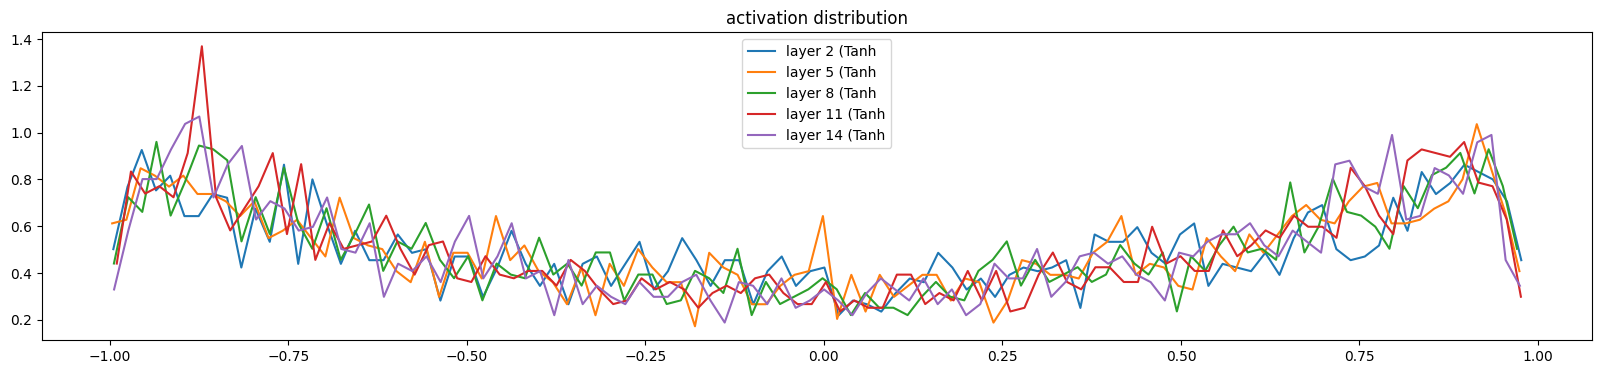

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.093912e-03
layer 5 (      Tanh): mean +0.000000, std 2.661322e-03
layer 8 (      Tanh): mean +0.000000, std 2.426213e-03
layer 11 (      Tanh): mean -0.000000, std 2.269459e-03
layer 14 (      Tanh): mean +0.000000, std 1.983031e-03


Text(0.5, 1.0, 'gradient distribution')

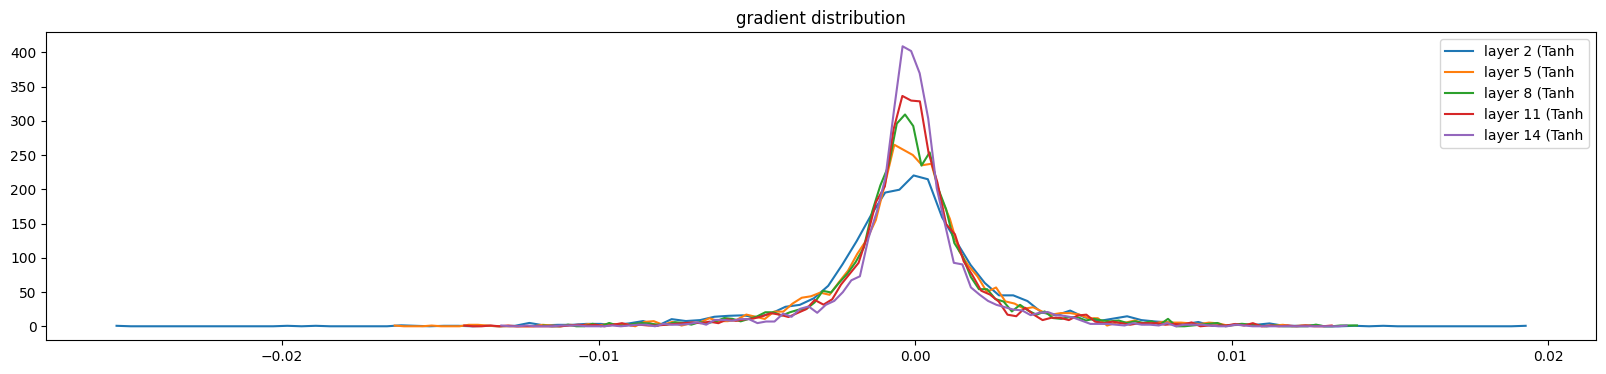

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 6.705950e-03 | grad:data ratio 6.700181e-03
weight  (30, 100) | mean -0.000003 | std 2.026518e-03 | grad:data ratio 1.977298e-03
weight (100, 100) | mean +0.000013 | std 1.104427e-03 | grad:data ratio 1.108056e-03
weight (100, 100) | mean +0.000005 | std 9.566543e-04 | grad:data ratio 9.497147e-04
weight (100, 100) | mean +0.000003 | std 8.406345e-04 | grad:data ratio 8.380437e-04
weight (100, 100) | mean +0.000001 | std 7.872587e-04 | grad:data ratio 7.840730e-04
weight  (100, 27) | mean -0.000002 | std 1.212761e-03 | grad:data ratio 1.226612e-03


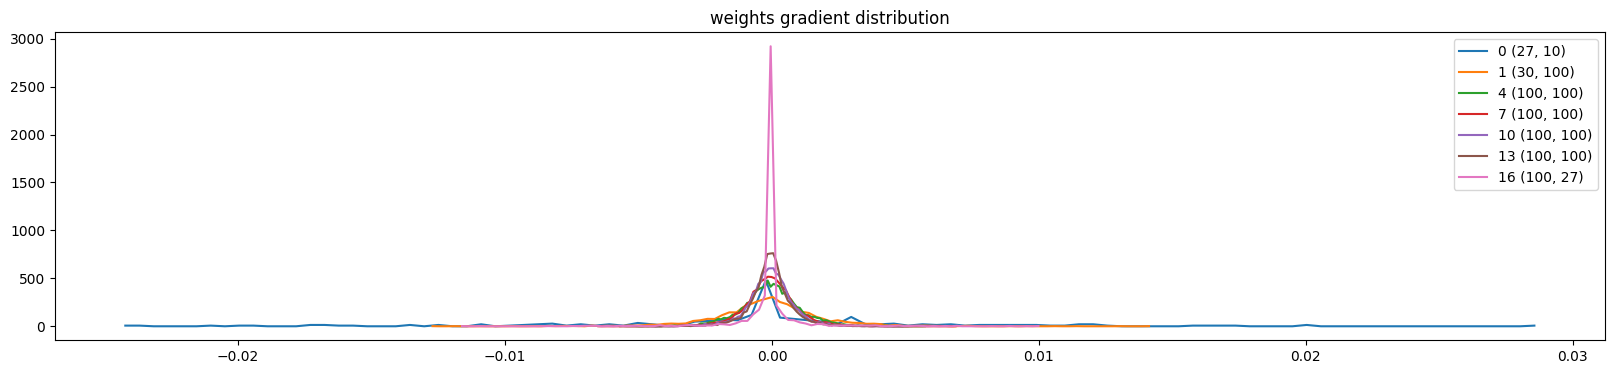

In [38]:
# visualize histograms
# grad to data ratio 
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # weights of linear layers
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

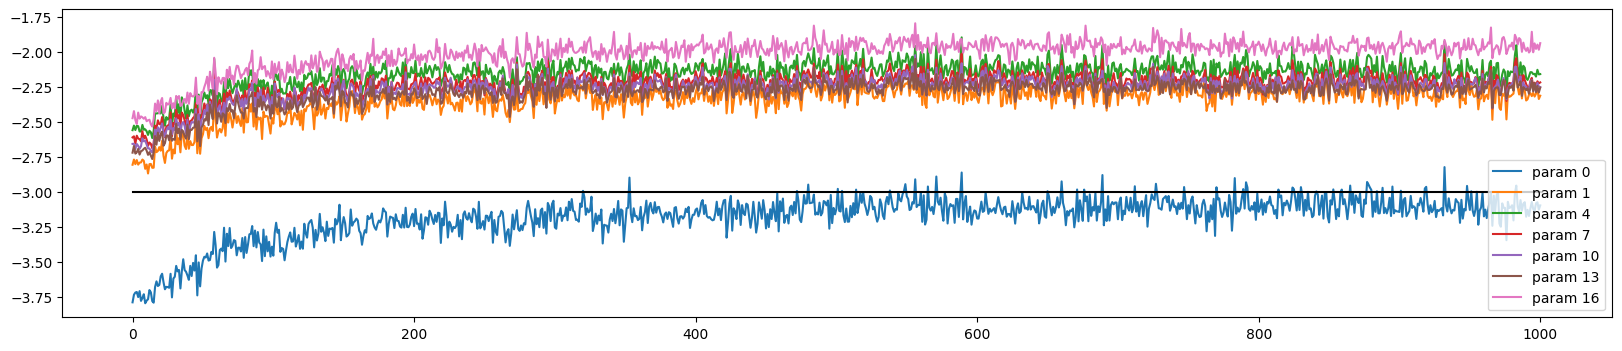

In [42]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
# https://youtu.be/P6sfmUTpUmc?t=6369

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.8620128631591797
val 2.8649933338165283


In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.862276077270508
val 2.8644816875457764


In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

narmahxaae.
hlrihkimrs.
reaty.
hnaassnejr.
hnenfamesyhc.
iaeei.
.
e.
maia.
ceaiiv.
e.
lein.
h.
.
m.
.
oin.
eeijn.
s.
lilea.
